In [18]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from IPython.display import HTML

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} \tag{10}$$


In [2]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)
# Hard Reset
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


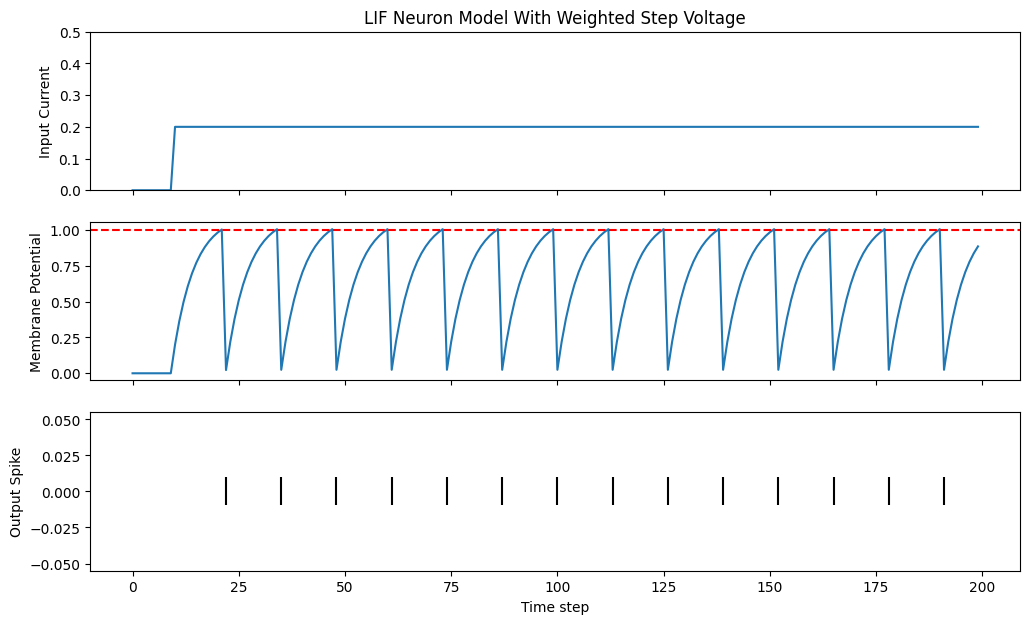

In [3]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

def plot_cur_mem_spk(x, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5, title=""):
    fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
    ax[0].plot(x)
    ax[0].set_ylim([0, ylim_max1])
    ax[0].set_ylabel("Input Current")
    ax[0].set_title(title)

    ax[1].plot(mem_rec)
    ax[1].axhline(y=thr_line, color='r', linestyle='--')
    ax[1].set_ylabel("Membrane Potential")

    splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
    ax[2].set_ylabel("Output Spike")
    ax[2].set_xlabel("Time step")

    plt.show()

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

The neuron model is now stored in `lif1`. To use this neuron:

**Inputs**
* `cur_in`: each element of $W\times X[t]$ is sequentially passed as an input
* `mem`: the previous step membrane potential, $U[t-1]$, is also passed as input.

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U[t]$ of the present step


$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{\beta S[t]U_{\rm thr}}_\text{soft reset} \tag{11}$$

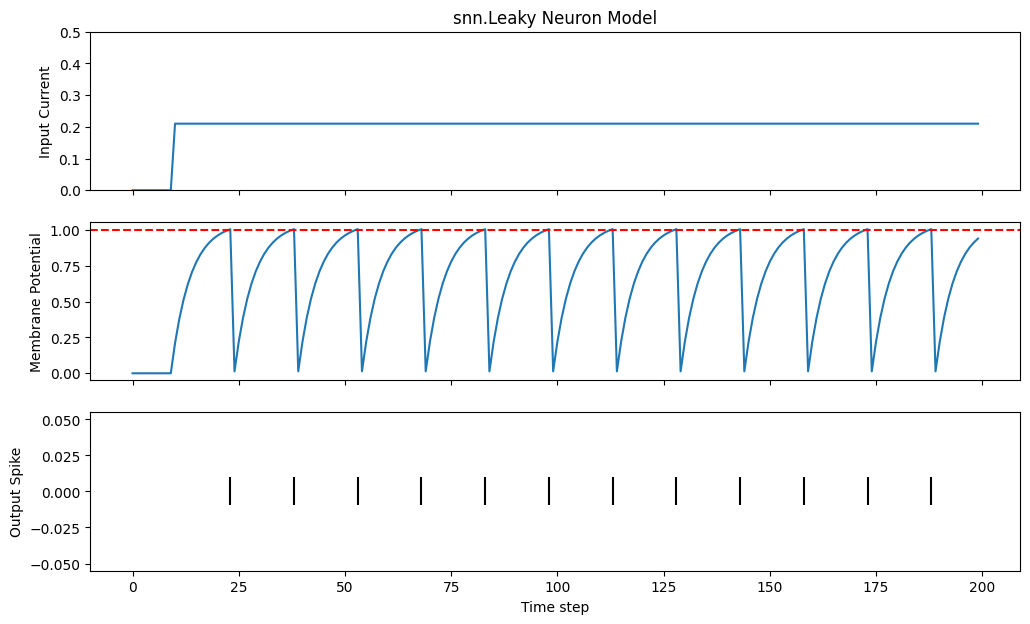

In [4]:
# Soft Reset
lif1 = snn.Leaky(beta=0.8)
# Small step current input
w = 0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

A Feedforward Spiking Neural Network

[$time \times batch\_size \times feature\_dimensions$]


*  The $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $X_{i} \times W_{ij}$
* This generates the input current term from Equation $(10)$, contributing to $U[t+1]$ of the spiking neuron
* If $U[t+1] > U_{\rm thr}$, then a spike is triggered from this neuron
* This spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons.
* If there is no spike, then nothing is passed to the post-synaptic neuron.

Dimensions of spk_in: torch.Size([200, 1, 784])


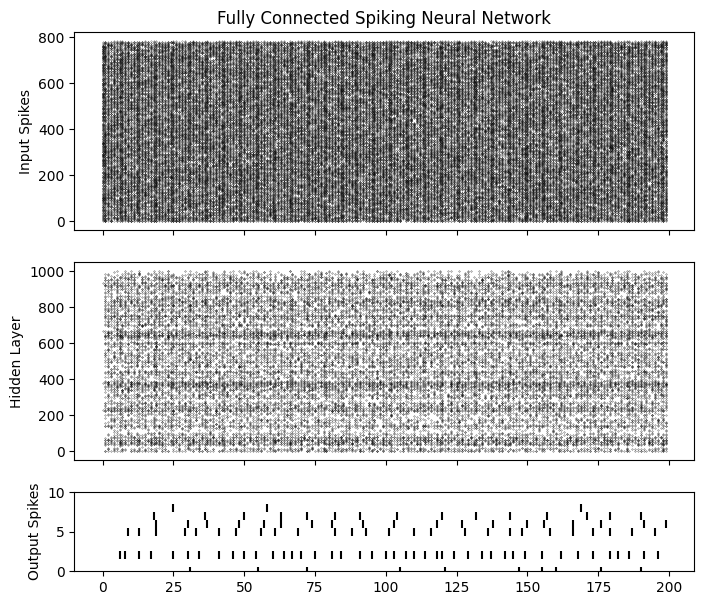

In [ ]:
def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)

fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")
    
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

lets you visualize the membrane potential traces. We will plot 9 out of 10 output neurons. Compare it to the animation and raster plot above to see if you can match the traces to the neuron.

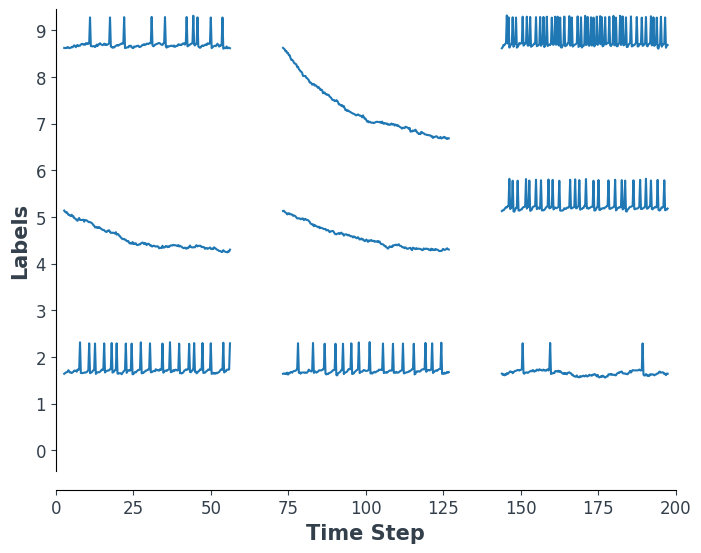

In [19]:
fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
# HTML(anim.to_html5_video())
anim.save("./notebooks/spike_plots/spike_bar.gif")

# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)